In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


We would follow the following steps for training the model
1. Data Prep
2. Defining CNN model
3. Defining Loss Function and optimiser
4. Training the model
5. Testing the model on testing data
6. Checking the misclassified images

In [6]:
# Data preparation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|██████████| 9912422/9912422 [00:01<00:00, 8676537.38it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 9585795.19it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2823827.09it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4546665.58it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [7]:
# Defining the model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0453
Epoch [2/5], Loss: 0.0066
Epoch [3/5], Loss: 0.1047
Epoch [4/5], Loss: 0.0143
Epoch [5/5], Loss: 0.0000


In [9]:
# Testing model using training data
model.eval()

correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(len(images), len(labels))
# print(len(images))
accuracy = correct / total

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy on the test set: {accuracy:.2%}')
print('Confusion Matrix:')
print(conf_matrix)

16 16
Accuracy on the test set: 98.92%
Confusion Matrix:
[[ 977    0    0    1    0    0    1    0    1    0]
 [   0 1129    1    1    0    0    2    0    1    1]
 [   0    0 1012    6    2    0    0   11    0    1]
 [   0    0    0 1008    0    1    0    0    0    1]
 [   0    0    0    0  974    0    0    1    0    7]
 [   1    0    0    8    0  874    4    0    0    5]
 [   3    1    0    0    3    2  948    0    1    0]
 [   0    3    2    1    0    0    0 1019    1    2]
 [   4    0    3    6    0    0    3    1  949    8]
 [   0    0    0    0    3    1    0    3    0 1002]]


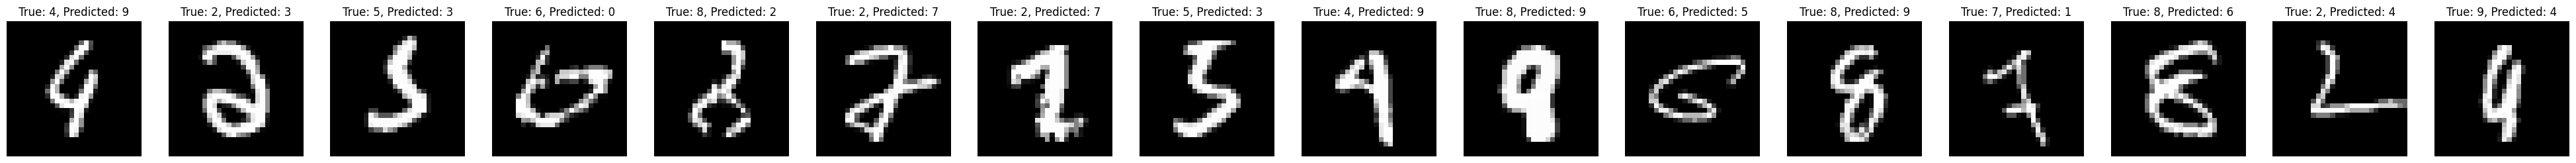

In [10]:
# Identify and store all misclassified images
misclassified_images = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Identify misclassified images in the current batch
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                misclassified_images.append((images[i], labels[i], predicted[i]))

# Display some misclassified images
num_to_display = min(len(misclassified_images), 16)

fig, axes = plt.subplots(1, num_to_display, figsize=(50, 50))

for i in range(num_to_display):
    image, true_label, pred_label = misclassified_images[i]
    axes[i].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title(f'True: {true_label}, Predicted: {pred_label}')
    axes[i].axis('off')

plt.show()

# Bonus Section

In [ ]:
# Using a pretrained model like ResNet for classification
# Ref - https://pylessons.com/Keras-ResNet-tutorial
from torchvision import models

# Data preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG requires a minimum size of 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Calling Pre-trained VGG Model
vgg_model = models.vgg16(pretrained=True)

# Modify the input layer to accept a single-channel image (MNIST is grayscale)
vgg_model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Modify the output layer to have 10 classes for MNIST
vgg_model.classifier[6] = nn.Linear(4096, 10)

# Defining Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)

# Step 5: Train the Model
num_epochs = 5

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = vgg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model using test data
vgg_model.eval()

correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = vgg_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy on the test set: {accuracy:.2%}')
print('Confusion Matrix:')
print(conf_matrix)